In [1]:
import jax
import flax
import jax.numpy as jnp
import pickle
from flax.serialization import from_state_dict
from src.subgoal_diffuser import GCDDPMBCAgent
from src.icvf_networks import LayerNormMLP
import h5py
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

Extra kwargs: {}


In [2]:
DIFF_PATHS = {
    "icvf-params": "/home/dashora7/experiment_output/diffusion_antmaze/icvf/icvf_param_large-diffusion/params.pkl",
    "ptrajgoal=1": "/home/dashora7/experiment_output/diffusion_antmaze/icvf/random-withintraj_large-diffusion/params.pkl",
    "icvf_weighted-sum": "/home/dashora7/experiment_output/diffusion_antmaze/icvf/withintraj-icvfsumweight-large-diffusion/params.pkl",
    "icvf_weighted-softmax": "/home/dashora7/experiment_output/diffusion_antmaze/icvf/icvf_weighted-softmax/params.pkl",
    "icvf_weighted-softmax-advstep": "/home/dashora7/experiment_output/diffusion_antmaze/icvf/icvf_weighted-softmax-advstep/params.pkl",
    "icvf_weighted-reachable": "/home/dashora7/experiment_output/diffusion_antmaze/icvf/icvfweighted-reachableonly/params.pkl",
    "icvf_weighted-useful": "/home/dashora7/experiment_output/diffusion_antmaze/icvf/icvfweighted-usefulonly/params.pkl"
}

In [15]:
diff_path = DIFF_PATHS["icvf_weighted-softmax"]
assert diff_path is not None, "Need to provide path to ICVF model!"    
with open(diff_path, 'rb') as f:
    diff_params = pickle.load(f)

params = diff_params['agent']
conf = diff_params['config']

# define encoder
hidden_dims = (256, 256)
encoder_def = LayerNormMLP(hidden_dims)

# initialize agent
rng = jax.random.PRNGKey(42)
rng, construct_rng = jax.random.split(rng)
agent = GCDDPMBCAgent.create(
    rng=construct_rng,
    observations=jnp.ones((1, 29)),
    goals=jnp.ones((1, 29)),
    actions=jnp.ones((1, 29)),
    encoder_def=encoder_def
)
agent = from_state_dict(agent, params)

def generate_subgoal(obs, goal):
    return agent.sample_actions(obs, goal, seed=jax.random.PRNGKey(42))
generate_subgoal = jax.jit(generate_subgoal)

In [16]:
start, end = 804804, 805114
fpath = '/home/dashora7/hard_antmaze.hdf5'
data = h5py.File(fpath, 'r')
obses = data['observations']
exp_slice = obses[start:end]
subgoal_idxs = [0, 30, 50, 90, 115, 135, 150, 175, 200, 225, 260, 285, 309]
goal = exp_slice[-1]

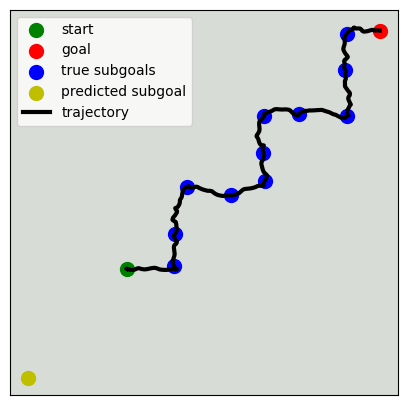

In [17]:
def plot_traj(traj, start, goal, true_subgoals):
    fig, ax = plt.subplots(figsize=(5, 5))
    sg_predicted = generate_subgoal(start, goal)
    ax.set_facecolor('xkcd:light grey')
    ax.grid(True, color='white')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.scatter(start[0], start[1], c='g', s=100, label='start')
    ax.scatter(goal[0], goal[1], c='r', s=100, label='goal')
    ax.scatter(true_subgoals[:, 0], true_subgoals[:, 1], c='b', s=100, label='true subgoals')
    ax.scatter(sg_predicted[0], sg_predicted[1], c='y', s=100, label='predicted subgoal')
    ax.plot(traj[:, 0], traj[:, 1], c='k', linewidth=3, label='trajectory')
    ax.legend()
    return fig

fig = plot_traj(
    exp_slice,
    exp_slice[0],
    exp_slice[-1],
    exp_slice[subgoal_idxs[1:-1], :2],
)

fig.show()

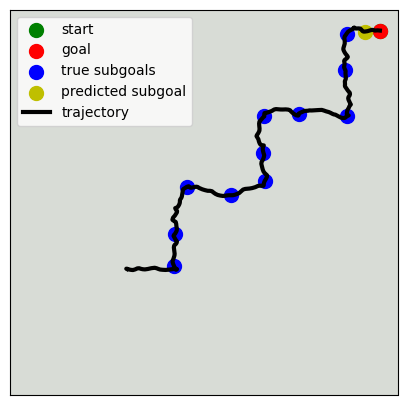

In [18]:
# make movie by creating plot as we move start position
fig = plot_traj(
    exp_slice,
    exp_slice[0],
    exp_slice[-1],
    exp_slice[subgoal_idxs[1:-1], :2],
)

def animation_func(i):
    # recompute subgoal
    start = exp_slice[i]
    sg_predicted = generate_subgoal(start, goal)
    # update plot
    fig.axes[0].collections[0].set_offsets(start[:2])
    fig.axes[0].collections[-1].set_offsets(sg_predicted[:2])
    return fig,

anim = animation.FuncAnimation(fig, animation_func, frames=exp_slice.shape[0], interval=100, blit=True)
HTML(anim.to_html5_video())